# Parkinson's Disease Detection

This notebook performs **K-Nearest Neighbors (KNN) classification** on biomedical voice measurements to detect **Parkinson’s Disease**. It provides an overview of the dataset and demonstrates the implementation of a **KNN pipeline** that simplifies the process of finding the optimal number of neighbors.  

The results show that the **KNN model achieves an accuracy of $87.3\pm0.4\%$**, successfully meeting the required baseline for this academic exercise.  

## Authors

- Airyll Sanchez
- Chris Andrei Irag*
- Jasmine Canaman
- Kobe Marco
- Visaviern Mosqueda

Group 2, DS3A, University of Science and Technology of Southern Philippines

*{chrisandrei.irag}@1.ustp.edu.ph

## Notebook Setup

In [92]:
# Data Transformation and Dataframes
import polars as pl

# Data Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.style import reload_library

# Scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Workstation directories
from machine_learning.config import MPLSTYLE_DIR

# Data retrieval
from ucimlrepo import fetch_ucirepo 

import warnings

parkinsons = fetch_ucirepo(id=174) 
  
# data (as pandas dataframes) 
X = parkinsons.data.features
X = X.loc[:, ~X.columns.duplicated()] # remove duplicate columns
y = parkinsons.data.targets

# Custom matplotlib styling
reload_library()
plt.style.use(MPLSTYLE_DIR / "iragca_ml.mplstyle")

warnings.filterwarnings("ignore")

## Problem

This notebook focuses on implementing the **K-Nearest Neighbors (KNN)** classification algorithm using existing **Parkinson’s Disease** data. Our goal is to determine whether a person has Parkinson’s Disease based on **biomedical voice measurements**. This notebook is inspired by the study [2], which assesses the suitability of using **Dysphonia** (hoarseness of voice) as a diagnostic feature. The dataset used in this notebook originates from that study.  

The researchers in the referenced study employed **Quadratic Discriminant Analysis (QDA)** to classify individuals as either **healthy (Class 0)** or has **Parkinson’s-positive (Class 1)**. Their model achieved an accuracy of **$91.8\pm2.0\%$** [3]. We will use this as a baseline to evaluate whether our KNN implementation can achieve comparable or improved performance aside from the academic requirement baseline of $80\%$.  


## Data Discussion

In [2]:
print(parkinsons.variables)

            name     role         type demographic description units  \
0           name       ID  Categorical        None        None  None   
1        MDVP:Fo  Feature   Continuous        None        None    Hz   
2       MDVP:Fhi  Feature   Continuous        None        None    Hz   
3       MDVP:Flo  Feature   Continuous        None        None    Hz   
4    MDVP:Jitter  Feature   Continuous        None        None     %   
5    MDVP:Jitter  Feature   Continuous        None        None   Abs   
6       MDVP:RAP  Feature   Continuous        None        None  None   
7       MDVP:PPQ  Feature   Continuous        None        None  None   
8     Jitter:DDP  Feature   Continuous        None        None  None   
9   MDVP:Shimmer  Feature   Continuous        None        None  None   
10  MDVP:Shimmer  Feature   Continuous        None        None    dB   
11  Shimmer:APQ3  Feature   Continuous        None        None  None   
12  Shimmer:APQ5  Feature   Continuous        None        None  

This data are biomedical voice measurements of people. The purpose of the data is to quantify the hoarseness (dysphonia) of a person's voice, which is one of the earliest signs of Parkinson's Disease [1].

The dataset mainly consists of continuous data, the target feature 'status' is categorical which classifies a healthy person as class 0 and a person with Parkinson's Disease as class 1.

In [3]:
print(X.shape), print(y.value_counts())
X

(195, 20)
status
1         147
0          48
Name: count, dtype: int64


,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00370,0.00554,0.01109,0.04374,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00465,0.00696,0.01394,0.06134,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00544,0.00781,0.01633,0.05233,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00502,0.00698,0.01505,0.05492,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00655,0.00908,0.01966,0.06425,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00263,0.00259,0.00790,0.04087,0.02336,0.02498,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.00331,0.00292,0.00994,0.02751,0.01604,0.01657,0.01879,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.00624,0.00564,0.01873,0.02308,0.01268,0.01365,0.01667,0.03804,0.10715,17.883,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.00370,0.00390,0.01109,0.02296,0.01265,0.01321,0.01588,0.03794,0.07223,19.020,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


Variable Descriptions:

 - MDVP:Fo(Hz) - Average vocal fundamental frequency
 - MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
 - MDVP:Flo(Hz) - Minimum vocal fundamental frequency
 - MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several measures of variation in fundamental frequency
 - MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude
 - NHR,HNR - Two measures of ratio of noise to tonal components in the voice
 - status - Health status of the subject (one) - Parkinson's, (zero) - healthy
 - RPDE,D2 - Two nonlinear dynamical complexity measures
 - DFA - Signal fractal scaling exponent
 - spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation

We have 20 features, 147 class 1 (PD) samples and 48 samples for class 0 (healthy)

## References

[1] A. Ma, K. K. Lau, and D. Thyagarajan, “Voice changes in Parkinson’s disease: What are they telling us?,” Journal of Clinical Neuroscience, vol. 72, pp. 1–7, Feb. 2020, doi: 10.1016/j.jocn.2019.12.029.

[2] M. A. Little and L. O. Ramig, “Suitability of dysphonia measurements for telemonitoring of Parkinson’s disease,” Nature Precedings, 2008.

[3] M. A. Little, P. E. McSharry, S. J. Roberts, D. A. Costello, and I. M. Moroz, “Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection,” BioMed Eng OnLine, vol. 6, no. 1, p. 23, 2007, doi: 10.1186/1475-925X-6-23.



## KNN Implementation

In this section we will be implementing K-Nearest Neighbors (KNN) on the parkinson's disease dataset. In one of the original papers, the top performing feature pair combinations was Recurrence Probability Density Entropy (RPDE) and Detrended Fluctuation Analysis (DFA)  which result in an overall accuracy **$91.8\pm2.0\%$** for their Quadratic Discriminant Analysis classifier. We will try to build on this as part of our feature engineering process.

#### Pipeline

This pipeline class will allow us to perform a grid search over neighbor parameters and the number of trials for each neighbor.

In [11]:
from typing import List, Tuple

import numpy as np
from loguru import logger
from tqdm import tqdm

class KNNPipeline:
    """A pipeline for evaluating K-Nearest Neighbors classifiers.

    This class handles the training, evaluation, and visualization of KNN models
    with support for multiple trials and grid search over different n_neighbors values.

    Attributes:
        features (pl.DataFrame): Input features for classification
        target (pl.Series): Target labels
        data_name (str): Name of the dataset being used
    """

    def __init__(self, features: pl.DataFrame, target: pl.Series, data_name: str = "Parkinsons"):
        self.features = features
        self.target = target
        self.data_name = data_name

    def evaluate(
        self, 
        n_neighbors: int, 
        trials: int = 50, 
        test_size: float = 0.25, 
        _verbose: bool = True, 
        metric: str = "minkowski"
    ) -> Tuple[float, float]:
        """Evaluate KNN model with multiple trials"""
        train_scores, test_scores = [], []

        if _verbose:
            progress_bar = tqdm(
                range(trials), desc=f"KNN ({trials} trials)", unit="trial", leave=False
            )
            logger.info(f"Starting KNN ({trials} trials)")

        for _ in progress_bar if _verbose else range(trials):
            X_train, X_test, y_train, y_test = train_test_split(
                self.features, self.target, test_size=test_size
            )
            model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric).fit(X_train, y_train)
            train_scores.append(model.score(X_train, y_train))
            test_scores.append(model.score(X_test, y_test))

        if _verbose:
            logger.info(f"Finished KNN ({trials} trials)")

        return np.mean(train_scores), np.mean(test_scores)

    def grid_search(
        self, n_neighbors: List[int], trials: int = 50, test_size: float = 0.25, plot: bool = True, metric: str = "minkowski"
    ) -> Tuple[List[float], List[float]]:
        """Perform grid search over different n_neighbors values"""
        logger.info(
            f"Starting Grid Search for {self.data_name}. "
            f"n_neighbors: {n_neighbors}, trials: {trials}"
        )

        train_means, test_means = [], []
        progress_bar = tqdm(
            n_neighbors, desc=f"Grid Search ({trials} trials)", unit="n_neighbors", leave=False
        )

        for n in progress_bar:
            train_mean, test_mean = self.evaluate(n, trials, test_size, _verbose=False, metric=metric)
            train_means.append(train_mean)
            test_means.append(test_mean)

        train_means, test_means = np.array(train_means), np.array(test_means)

        chart = None
        if plot:
            chart = self._plot_results(n_neighbors, train_means, test_means, trials, metric, test_size)

        logger.success(
            f"Finished Grid Search for {self.data_name}"
        )

        class KNNResults:
            def __init__(self, train_means, test_means, data_name, chart, hyperparameters: dict):
                self.train_means = train_means
                self.test_means = test_means
                self.data_name = data_name
                self.chart = chart
                self.hyperparameters = hyperparameters

            def __str__(self):
                hp = self.hyperparameters
                return (f"""
📄 KNN Results for {self.data_name}: 
    Metric:     {hp["metric"]}
    Trials:     {hp["trials"]} 
    Test size:  {hp["test_size"]}

    Grid Search neighbors: {hp["n_neighbors"]}

🎯 ==============================
\033[34mTrain max accuracy: {self.train_means.max()}\033[0m
    \033[34mat n_neighbors: {self.train_means.argmax() + 1}\033[0m
\033[33mTest max accuracy: {self.test_means.max()}
    \033[33mat n_neighbors: {self.test_means.argmax() + 1}\033[0m
🎯 ==============================
                """)
            
            def __repr__(self):
                hp = self.hyperparameters
                return (f"""
📄 KNN Results for {self.data_name}: 
    Metric:     {hp["metric"]}
    Trials:     {hp["trials"]} 
    Test size:  {hp["test_size"]}

    Grid Search neighbors: {hp["n_neighbors"]}

🎯 ==============================
\033[34mTrain max accuracy: {self.train_means.max()}\033[0m
    \033[34mat n_neighbors: {self.train_means.argmax() + 1}\033[0m
\033[33mTest max accuracy: {self.test_means.max()}
    \033[33mat n_neighbors: {self.test_means.argmax() + 1}\033[0m
🎯 ==============================
""")

        return KNNResults(
            train_means, test_means, self.data_name, chart,
            hyperparameters={
                "n_neighbors": n_neighbors, 
                "trials": trials, 
                "test_size": test_size, 
                "metric": metric
                }
            )

    def _plot_results(
        self,
        n_neighbors: List[int],
        train_means: List[float],
        test_means: List[float],
        trials: int,
        metric: str,
        test_size: int,
    ):
        """Plot the grid search results"""
        fig, ax = plt.subplots(figsize=(4, 2.5))

        sns.lineplot(ax=ax, x=n_neighbors, y=train_means, label="Train")
        sns.lineplot(ax=ax, x=n_neighbors, y=test_means, label="Test")

        ax.set_title(f"{metric}, {trials} trials, test size: {test_size}", size=14)
        ax.set_xlabel("Number of Neighbors")
        ax.set_ylabel("Mean Accuracy")

        plt.legend()
        plt.grid(True)
        plt.show()

        return fig


#### Feature Engineering and EDA

Let's see some basic overview of our data

<Axes: >

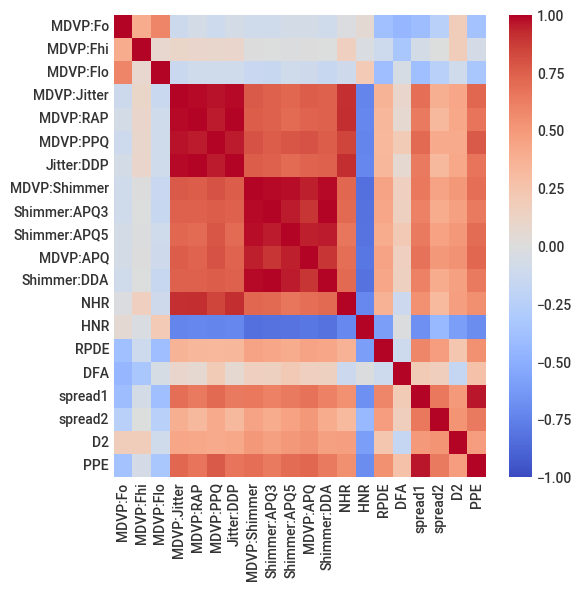

In [5]:
plt.figure(figsize=(6,6))
sns.heatmap(X.corr(), cmap='coolwarm', vmin=-1, vmax=1)

In [6]:
features = ['RPDE', 'DFA']
X[features].head(3)

,RPDE,DFA
0,0.414783,0.815285
1,0.458359,0.819521
2,0.429895,0.825288


<Axes: xlabel='RPDE', ylabel='Count'>

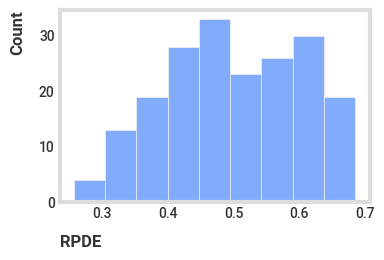

In [7]:
sns.histplot(X['RPDE'])

<Axes: xlabel='DFA', ylabel='Count'>

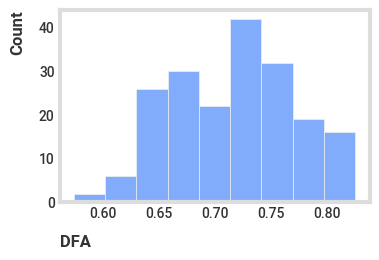

In [8]:
sns.histplot(X['DFA'])

##### Grid Searching

Let's apply the RPDE and DFA combination and hope to get a comparable or better performance to our baseline, which was $91.8\pm2.0\%$ based on the QDA model.

2025-02-23 22:18:16.386 | INFO     | __main__:grid_search:58 - Starting Grid Search for Parkinsons. n_neighbors: range(1, 101), trials: 100


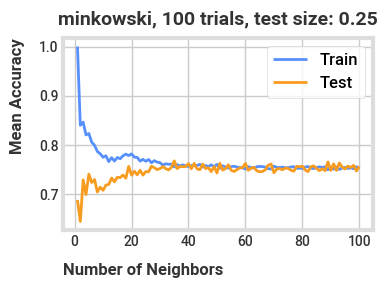

2025-02-23 22:21:25.599 | SUCCESS  | __main__:grid_search:79 - Finished Grid Search for Parkinsons

📄 KNN Results for Parkinsons: 
    Metric:     minkowski
    Trials:     100 
    Test size:  0.25

    Grid Search neighbors: range(1, 101)

🎯 ==============================
Train max accuracy: 1.0
    at n_neighbors: 1
Test max accuracy: 0.7679591836734693
    at n_neighbors: 35
🎯 ==============================
                


In [62]:
features = ['RPDE', 'DFA']
knn_pipe = KNNPipeline(X[features], y)

results = knn_pipe.grid_search(
        n_neighbors=range(1, 101), 
        trials=100,
        test_size=0.25, 
        metric="minkowski"
    )

print(results)

Our accuracy seems to converge at ~0.77, way off our baseline. Let's try adding some features.

2025-02-23 20:42:37.236 | INFO     | __main__:grid_search:58 - Starting Grid Search for Parkinsons. n_neighbors: range(1, 101), trials: 100


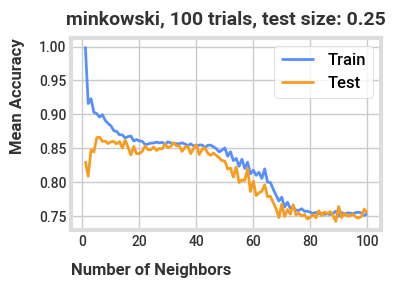

2025-02-23 20:45:52.935 | SUCCESS  | __main__:grid_search:79 - Finished Grid Search for Parkinsons

📄 KNN Results for Parkinsons: 
    Metric:     minkowski
    Trials:     100 
    Test size:  0.25

    Grid Search neighbors: range(1, 101)

🎯 ==============================
Train max accuracy: 1.0
    at n_neighbors: 1
Test max accuracy: 0.8665306122448979
    at n_neighbors: 6
🎯 ==============================
                


In [ ]:
features = [
        "RPDE", "DFA", 
        "spread1", "spread2",
        "PPE"
    ]
knn_pipe = KNNPipeline(X[features], y)

results = knn_pipe.grid_search(
        n_neighbors=range(1, 101), 
        trials=100,
        test_size=0.25, 
        metric="minkowski"
    )

print(results)

Our accuracy remains steady at around $85\%$, but it drops significantly when using $40$ or more neighbors then converges around $75\%$.

However, we achieved better performance in classifying whether a person has Parkinson’s Disease. Our accuracy increased by approximately $12.25\%$! 🚀

Let’s see if we can improve it even further!

2025-02-23 20:21:39.687 | INFO     | __main__:grid_search:58 - Starting Grid Search for Parkinsons. n_neighbors: range(1, 101), trials: 100


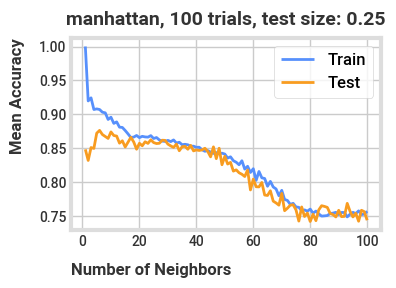

2025-02-23 20:24:49.332 | SUCCESS  | __main__:grid_search:79 - Finished Grid Search for Parkinsons

📄 KNN Results for Parkinsons: 
    Metric:     manhattan
    Trials:     100 
    Test size:  0.25

    Grid Search neighbors: range(1, 101)

🎯 ==============================
Train max accuracy: 1.0
    at n_neighbors: 1
Test max accuracy: 0.8763265306122447
    at n_neighbors: 6
🎯 ==============================
                


In [ ]:
features = [
        "RPDE", "DFA", 
        "spread1", "spread2",
        "PPE"
    ]
knn_pipe = KNNPipeline(X[features], y)

results = knn_pipe.grid_search(
        n_neighbors=range(1, 101), 
        trials=100,
        test_size=0.25, 
        metric="manhattan"
    )

print(results)

2025-02-23 20:26:09.296 | INFO     | __main__:grid_search:58 - Starting Grid Search for Parkinsons. n_neighbors: range(1, 101), trials: 100


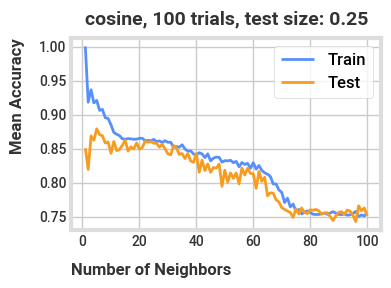

2025-02-23 20:29:20.959 | SUCCESS  | __main__:grid_search:79 - Finished Grid Search for Parkinsons

📄 KNN Results for Parkinsons: 
    Metric:     cosine
    Trials:     100 
    Test size:  0.25

    Grid Search neighbors: range(1, 101)

🎯 ==============================
Train max accuracy: 1.0
    at n_neighbors: 1
Test max accuracy: 0.8789795918367348
    at n_neighbors: 5
🎯 ==============================
                


In [ ]:
features = [
        "RPDE", "DFA", 
        "spread1", "spread2",
        "PPE"
    ]
knn_pipe = KNNPipeline(X[features], y)

cos_results = knn_pipe.grid_search(
        n_neighbors=range(1, 101), 
        trials=100,
        test_size=0.25, 
        metric="cosine"
    )

print(cos_results)

This time we tried using manhattan and cosine metrics. Cosine turned out to be marginally better. Let's try to reinforce with 1000 trials

2025-02-23 21:05:38.304 | INFO     | __main__:grid_search:58 - Starting Grid Search for Parkinsons. n_neighbors: range(1, 21), trials: 1000


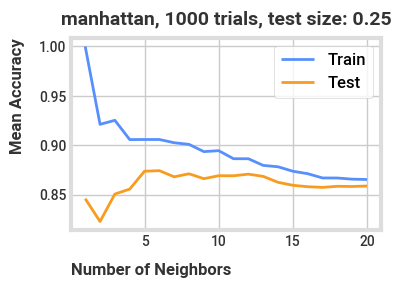

2025-02-23 21:11:32.624 | SUCCESS  | __main__:grid_search:79 - Finished Grid Search for Parkinsons

📄 KNN Results for Parkinsons: 
    Metric:     manhattan
    Trials:     1000 
    Test size:  0.25

    Grid Search neighbors: range(1, 21)

🎯 ==============================
Train max accuracy: 1.0
    at n_neighbors: 1
Test max accuracy: 0.8744489795918368
    at n_neighbors: 6
🎯 ==============================
                


In [ ]:
features = [
        "RPDE", "DFA", 
        "spread1", "spread2",
        "PPE"
    ]
knn_pipe = KNNPipeline(X[features], y)

man_results = knn_pipe.grid_search(
        n_neighbors=range(1, 21), 
        trials=1000,
        test_size=0.25, 
        metric="manhattan"
    )

print(man_results)

2025-02-23 21:11:33.190 | INFO     | __main__:grid_search:58 - Starting Grid Search for Parkinsons. n_neighbors: range(1, 21), trials: 1000


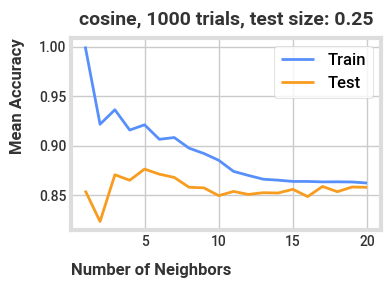

2025-02-23 21:17:38.424 | SUCCESS  | __main__:grid_search:79 - Finished Grid Search for Parkinsons

📄 KNN Results for Parkinsons: 
    Metric:     cosine
    Trials:     1000 
    Test size:  0.25

    Grid Search neighbors: range(1, 21)

🎯 ==============================
Train max accuracy: 1.0
    at n_neighbors: 1
Test max accuracy: 0.8764693877551021
    at n_neighbors: 5
🎯 ==============================
                


In [ ]:
features = [
        "RPDE", "DFA", 
        "spread1", "spread2",
        "PPE"
    ]
knn_pipe = KNNPipeline(X[features], y)

cos_results = knn_pipe.grid_search(
        n_neighbors=range(1, 21), 
        trials=1000,
        test_size=0.25, 
        metric="cosine"
    )

print(cos_results)

The differences seem trivial however let's try to get the confidence intervals of accuracy means from 1-20 neighbors

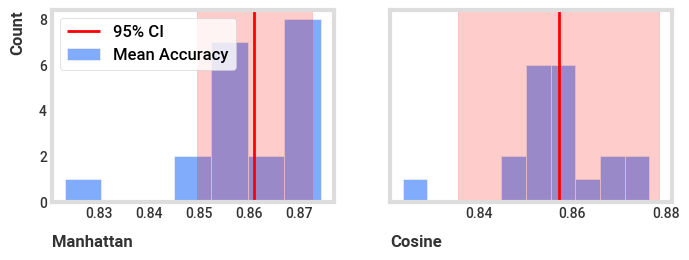

In [118]:
man_means = man_results.test_means
cos_means = cos_results.test_means

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2.5), sharey=True)

sns.histplot(ax=ax1, x=man_means, label='Mean Accuracy')
ax1.axvline(x=man_means.mean(), color='red', label='95% CI')
ax1.axvspan(
    man_means.mean() - man_means.std(), 
    man_means.mean() + man_means.std(), 
    color='red', alpha=0.2
)
ax1.set_xlabel("Manhattan")

sns.histplot(ax=ax2, x=cos_means, label='Mean Accuracy')
ax2.axvline(x=cos_means.mean(), color='red', label='95% CI')
ax2.axvspan(
    cos_means.mean() - (cos_means.std() * 2), 
    cos_means.mean() + (cos_means.std() * 2), 
    color='red', alpha=0.2
    )
ax2.set_xlabel("Cosine")

ax1.legend(loc='upper left') 

Based on the chart, we can see that Manhattan distance is slightly better due to a tigher confidence interval and higher mean. So let's settle with manhattan distance. Let's try with more features so that we can surpass our baseline.

In [ ]:
X.columns

Index(['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:Jitter', 'MDVP:RAP',
       'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'Shimmer:APQ3',
       'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

2025-02-24 10:54:41.746 | INFO     | __main__:grid_search:58 - Starting Grid Search for Parkinsons. n_neighbors: range(1, 21), trials: 10


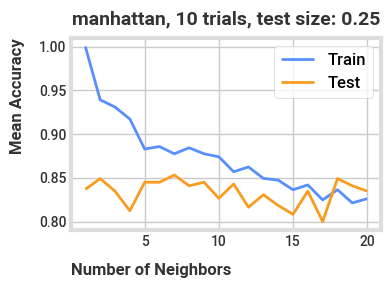

2025-02-24 10:54:45.432 | SUCCESS  | __main__:grid_search:79 - Finished Grid Search for Parkinsons

📄 KNN Results for Parkinsons: 
    Metric:     manhattan
    Trials:     10 
    Test size:  0.25

    Grid Search neighbors: range(1, 21)

🎯 ==============================
Train max accuracy: 1.0
    at n_neighbors: 1
Test max accuracy: 0.8530612244897959
    at n_neighbors: 7
🎯 ==============================
                


In [198]:
features = [
        "RPDE", "DFA", 
        "spread1", "spread2",
        "PPE", "D2",
        "MDVP:Jitter", "MDVP:Flo",
        "MDVP:RAP", "MDVP:PPQ",
        "Jitter:DDP", "NHR",
        "Shimmer:DDA"
    ]
knn_pipe = KNNPipeline(X[features], y)

results = knn_pipe.grid_search(
        n_neighbors=range(1, 21), 
        trials=10,
        test_size=0.25, 
        metric="manhattan"
    )

print(results)

2025-02-24 10:55:02.955 | INFO     | __main__:grid_search:58 - Starting Grid Search for Parkinsons. n_neighbors: range(1, 21), trials: 100


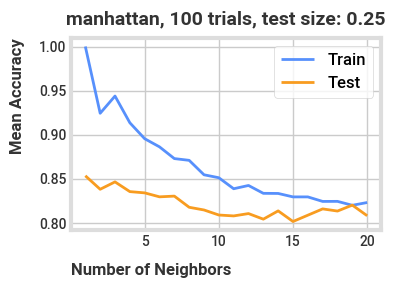

2025-02-24 10:55:43.038 | SUCCESS  | __main__:grid_search:79 - Finished Grid Search for Parkinsons

📄 KNN Results for Parkinsons: 
    Metric:     manhattan
    Trials:     100 
    Test size:  0.25

    Grid Search neighbors: range(1, 21)

🎯 ==============================
Train max accuracy: 1.0
    at n_neighbors: 1
Test max accuracy: 0.8534693877551021
    at n_neighbors: 1
🎯 ==============================
                


In [199]:
features = X.columns
knn_pipe = KNNPipeline(X[features], y)

all_results = knn_pipe.grid_search(
        n_neighbors=range(1, 21), 
        trials=100,
        test_size=0.25, 
        metric="manhattan"
    )

print(all_results)

Using all features seem to result in a worse score and add additional features seem unnecessary. Let's settle with less. 

Let's do 1000x100 trials using Cosine similarity with 5 neighbors and get the 95% confidence interval.

In [200]:
BEST_METRIC = "manhattan"
BEST_NEIGHBOR = 5
BEST_FEATURES = [
        "RPDE", "DFA", 
        "spread1", "spread2",
        "PPE"
    ]

SAMPLES = 1000
TRIALS = 100
accuracies = np.zeros((TRIALS, SAMPLES))

for sample in tqdm(range(SAMPLES), unit="sample"):
    for trial in range(TRIALS):
        cos_knn = KNeighborsClassifier(n_neighbors=BEST_NEIGHBOR, metric=BEST_METRIC)
        X_train, X_test, y_train, y_test = train_test_split(X[BEST_FEATURES], y, test_size=0.25)
        cos_knn.fit(X_train, y_train)
        accuracies[trial-1, sample-1] = cos_knn.score(X_test, y_test)


  0%|          | 0/1000 [00:00<?, ?sample/s]

100%|██████████| 1000/1000 [13:21<00:00,  1.25sample/s]


In [201]:
accuracies.mean(axis=1).shape

(100,)

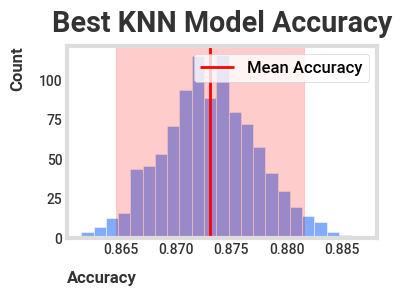

In [203]:
best, ax = plt.subplots(figsize=(4, 2.5))

mean_of_means = accuracies.mean(axis=0).mean()
std_of_means = accuracies.mean(axis=0).std()
left_ci = mean_of_means - std_of_means * 2
right_ci = mean_of_means + std_of_means * 2

sns.histplot(ax=ax, x=accuracies.mean(axis=0))
ax.axvline(x=mean_of_means, color='red', label='Mean Accuracy')
ax.axvspan(
    left_ci, right_ci,
    color='red', alpha=0.2
)
plt.xlabel("Accuracy")
plt.title("Best KNN Model Accuracy")
plt.legend()

In [204]:
left_ci, right_ci

(np.float64(0.864520048518385), np.float64(0.8815897473999814))

In [206]:
mean_of_means, std_of_means

(np.float64(0.8730548979591832), np.float64(0.00426742472039909))

We get an accuracy of $0.873\pm0.004$

## Discussion

Let's finalize our best results.


📄 KNN Results for Parkinsons: 
    Metric:     cosine
    Trials:     1000 
    Test size:  0.25

    Grid Search neighbors: range(1, 21)

🎯 ==============================
Train max accuracy: 1.0
    at n_neighbors: 1
Test max accuracy: 0.8764693877551021
    at n_neighbors: 5
🎯 ==============================
                


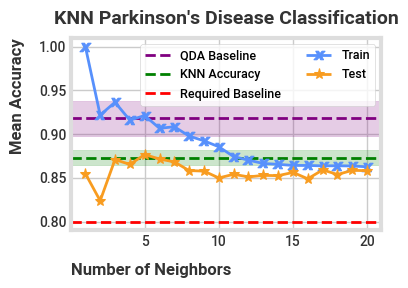

In [211]:
# Confidence intervals
cm = cos_results.test_means
stdx2 = cm.std() * 2

# Baseline and confidence interval
plt.axhline(0.918, color="purple", linestyle="--", label="QDA Baseline")
plt.axhspan(0.918 - 0.02, 0.918 + 0.02, color="purple", alpha=0.2)

# # 1-20 neighbor Confidence interval
# plt.axhline(cm.mean(), color="gray", linestyle="--", label="Mean Acc.")
# plt.axhspan(cm.mean() - stdx2, cm.mean() + stdx2, color="gray", alpha=0.2)

# Accuracy
plt.axhline(mean_of_means, color="green", linestyle="--", label="KNN Accuracy")
plt.axhspan(
    mean_of_means - std_of_means*2, 
    mean_of_means + std_of_means*2, 
    color="green", alpha=0.2
)

# Exercise accuracy requirement
plt.axhline(0.80, color="red", linestyle="--", label="Required Baseline")

# Plot best results
sns.lineplot(
    x=range(1, 21), y=cos_results.train_means, marker="$x$", label="Train", markeredgecolor="auto"
)
sns.lineplot(
    x=range(1, 21), y=cos_results.test_means, marker="*", label="Test", markeredgecolor="auto"
)

plt.title("KNN Parkinson's Disease Classification", size=14)
plt.xlabel("Number of Neighbors")
plt.ylabel("Mean Accuracy")
plt.legend(ncol=2, fontsize=9)
plt.grid(True)

print(cos_results)

In [123]:
cm.mean(), stdx2

(np.float64(0.857015306122449), np.float64(0.021480523514623796))

We started off with setting a QDA baseline accuracy of $91.8\pm2.0\%$ from the original paper and the required baseline of $80\%$ We started off with the best feature pair. We resulted with an initial accuracy of $75\%$. We improved our accuracy by an additional ~$13\%$ in accuracy by choosing manhattan distance as our metric and use the features "RPDE", "DFA", "spread1", "spread2", and "PPE". Additional features had no significant additional performance to the KNN Classifier.

### Highlights

1. Best features were "RPDE", "DFA", "spread1", "spread2", and "PPE".

2. Best number of neighbors is 5 and best metric is Manhattan.

3. We didn't surpass the QDA, but our best KNN achieved $87.3\pm0.4%$, meeting 80%.